## Linear Coefficient Validation Notebook
##### Logan Kelsch - 9/29/25-9/30/25

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



data_in = pd.read_csv('../../counts_xy_true_vs_yolo_series.csv')
data_in

,frame_index,true_count,yolo_predicted_count,accuracy_pct
0,30,4,3,0.750000
1,46,5,4,0.800000
2,50,6,4,0.666667
3,58,8,5,0.625000
4,70,10,8,0.800000
...,...,...,...,...
88,7140,1535,1388,0.904235
89,7346,1575,1420,0.901587
90,7466,1598,1445,0.904255
91,7502,1602,1448,0.903870


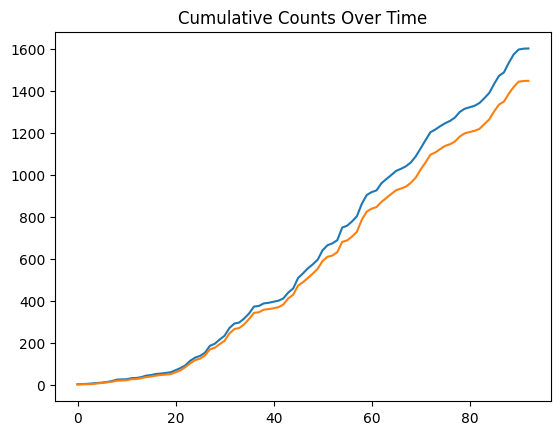

In [2]:
#i hate pandas and i love numpy
data = data_in.values

plt.plot(data[:, [1,2]])
plt.title("Cumulative Counts Over Time")
plt.show()

[]

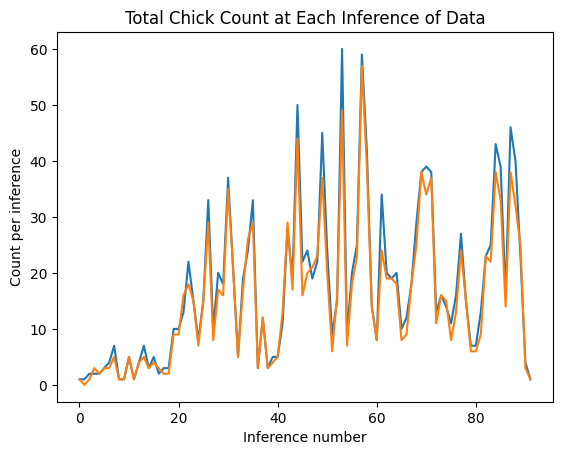

In [4]:
#vect/mat length
m = data.shape[0]

#malloc
data_d = np.empty((m-1,3), dtype=np.float32)

#column 0 is number of delta of frames
#column 1 and 2 are true and predicted
#		number of chicks since last observation

#delta assignment to variable at each instance i against i-1
for i in range(1, m):
	data_d[i-1] = data[i, [0,1,2]] - data[i-1, [0,1,2]]

#for this to be determined as a linear issue
#we should be able to randomly segment this data at any point with some test split
#collection some coefficient
#and it should land about exactly the same for all splits around zero error

#renaming
d_true = data_d[:, 1]
d_pred = data_d[:, 2]

#plotting
plt.plot(d_true)
plt.plot(d_pred)
plt.title("Total Chick Count at Each Inference of Data")
plt.xlabel("Inference number")
plt.ylabel("Count per inference")
plt.plot()

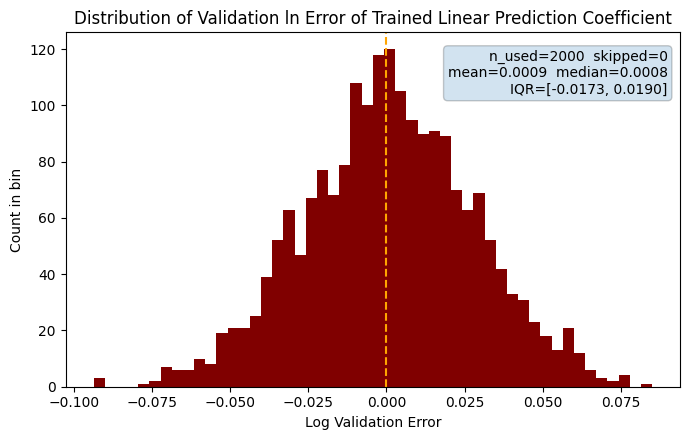

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def mc_log_ratio_counting(
    d_true: np.ndarray,
    d_pred: np.ndarray,
    train_percent: float = 0.7,
    n_iters: int = 2000,
    rng: np.random.Generator | None = None, #suggested method by chatgpt
    eps: float = 1e-12,           
    skip_zero_sums: bool = False, # if True, skip splits where sums <= 0 instead of adding eps
    plot: bool = True,
):
    """
    INFO
    ----
    i love Monte Carlo me and him are best friends
    if you read this function description tell Logan Kelsch "scooba"
    
    ALGORITHM
    ---------
    Monte Carlo random-split test for counting data using log error:
      log_err = ln( p_va / (t_va * r) ), with r = sum(p_tr)/sum(t_tr).

    RETURNS
    -------
    Returns a dict with the per-split log errors and summary stats, and
    (optionally) shows a histogram.
    """

    #sanity 1 // interpretation assurance
    d_true = np.asarray(d_true)
    d_pred = np.asarray(d_pred)
    assert d_true.shape == d_pred.shape and d_true.ndim == 1, "Inputs must be 1D and same shape."

    m = d_true.size
    assert 0 < train_percent < 1 and m >= 2, "Need 0<train_percent<1 and at least 2 samples."

    #clip
    k = max(1, int(round(train_percent * m)))
    k = min(k, m - 1)  # keep both sets non-empty

    #sanity 2
    if rng is None:
        rng = np.random.default_rng()

    #initiation
    log_errs = []
    skipped = 0

    #iterative loop for each simulation
    
    #NOTE SIMULATION DESCRIPTION NOTE
    #--------------------------------
    #ultimately we are training a linear coefficient on
    #   some training split _tr,
    #       and evaluating on
    #   some validation split _va

    for _ in range(n_iters):
        
        #get permutation metadata
        idx = rng.permutation(m)
        #instatiate permutation
        tr, va = idx[:k], idx[k:]

        #sum up for each inference
        t_tr = d_true[tr].sum()
        p_tr = d_pred[tr].sum()
        t_va = d_true[va].sum()
        p_va = d_pred[va].sum()

        #probably will not use this
        if skip_zero_sums:
            # Strict handling: require positive sums to define r and log
            if t_tr <= 0 or t_va <= 0 or p_va <= 0:
                skipped += 1
                continue
            r = p_tr / t_tr
            if r <= 0:
                skipped += 1
                continue
            log_err = np.log(p_va / (t_va * r))

        #really can only image seeing this case in use
        else:
            #epsilon stabilized handling
            tt = t_tr if t_tr > 0 else eps
            r = (p_tr + eps) / (tt + eps)
            #get log error
            log_err = np.log((p_va + eps) / ((t_va + eps) * max(r, eps)))

        log_errs.append(log_err)

    #misc stats, should never hit a np.nan but have it as a base case
    log_errs = np.asarray(log_errs, dtype=float)
    mean_ = float(np.mean(log_errs)) if log_errs.size else np.nan
    med_  = float(np.median(log_errs)) if log_errs.size else np.nan
    p25, p75 = (np.percentile(log_errs, [25, 75]) if log_errs.size else (np.nan, np.nan))

    #able to plot if requested AND have valid plottable data
    if plot and log_errs.size:

        #honestly chatgpt'd this I did not feel like getting the text and formatting by hand
        plt.figure(figsize=(7, 4.5))
        plt.hist(log_errs, bins=50, color='maroon')
        plt.axvline(0.0, linestyle="--", c='orange')#dont tell anyone this is not gold these are maroon colors but you cant see gold crying emoji
        plt.title("Distribution of Validation ln Error of Trained Linear Prediction Coefficient")
        plt.xlabel("Log Validation Error")
        plt.ylabel("Count in bin")
        txt = (f"n_used={log_errs.size}  skipped={skipped}\n"
               f"mean={mean_:.4f}  median={med_:.4f}\n"
               f"IQR=[{p25:.4f}, {p75:.4f}]")
        plt.gca().text(0.98, 0.95, txt, transform=plt.gca().transAxes,
                       ha="right", va="top", bbox=dict(boxstyle="round", alpha=0.2))
        plt.tight_layout()
        plt.show()

    #chatgpt also suggested this for the following kde function below
    #ended up working flawlessly so I am keeping it
    return {
        "log_errs": log_errs,
        "mean": mean_,
        "median": med_,
        "iqr": (p25, p75),
        "n_used": int(log_errs.size),
        "n_skipped": int(skipped),
    }

#generate some randomness and assertions and run on data
rng = np.random.default_rng(7)
#m = 800
#d_true = rng.poisson(5.0, size=m)
#bias = 1.12
#noise = rng.normal(0, 0.5, size=m)
#d_pred = np.clip(bias * d_true + noise, 0, None)
out = mc_log_ratio_counting(d_true, d_pred, train_percent=0.5, n_iters=2000, rng=rng)
#print(out["median"], out["iqr"])


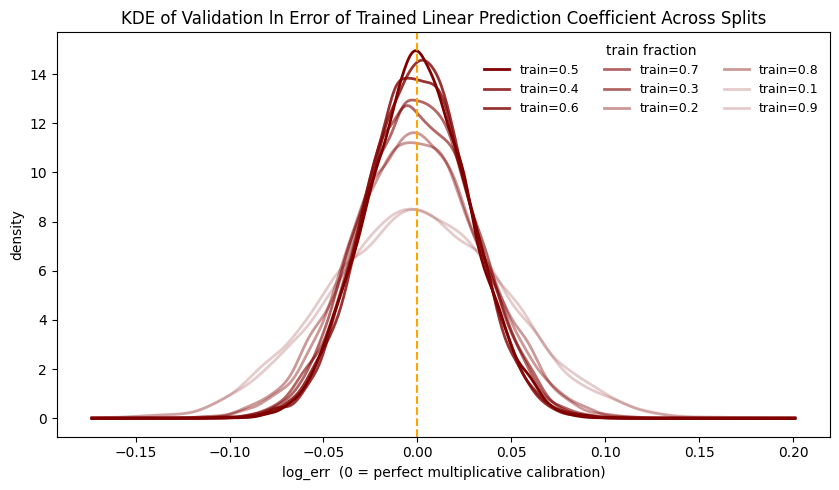

In [6]:
def _silverman_bandwidth(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    n = x.size
    if n < 2:
        return 1.0
    sd = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    sigma = min(sd, iqr / 1.34) if (sd > 0 and iqr > 0) else max(sd, iqr / 1.34, 1e-6)
    h = 0.9 * sigma * n ** (-1/5)
    return max(h, 1e-6)

def _kde_1d(x: np.ndarray, grid: np.ndarray, bw: float | None = None) -> np.ndarray:
    # Gaussian KDE: (1/(n*h*sqrt(2π))) * sum exp(-0.5*((grid - xi)/h)^2)
    x = np.asarray(x, dtype=float)
    grid = np.asarray(grid, dtype=float)
    n = x.size
    if n == 0:
        return np.zeros_like(grid)
    h = _silverman_bandwidth(x) if bw is None else max(float(bw), 1e-12)
    u = (grid[:, None] - x[None, :]) / h
    dens = np.exp(-0.5 * u * u).sum(axis=1) / (n * h * np.sqrt(2 * np.pi))
    return dens

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

def sweep_train_kdes(
    d_true: np.ndarray,
    d_pred: np.ndarray,
    train_percents: list[float] | np.ndarray = None,
    n_iters: int = 1000,
    rng: np.random.Generator | None = None,
    grid_points: int = 512,
    x_pad_std: float = 3.0,
    eps: float = 1e-12,
    skip_zero_sums: bool = False,
    show: bool = True,
):
    """
    Runs mc_log_ratio_counting over a set of train_percent values and plots KDEs.
    Colors: maroon with alpha that fades linearly with |train_percent - 0.5|.
    At 0.5 -> alpha = 1.0; at 0.1/0.9 -> alpha = 0.5.
    """
    if train_percents is None:
        train_percents = [i / 10 for i in range(1, 10)]  # 0.1..0.9

    if rng is None:
        rng = np.random.default_rng()

    # 1) Collect log_errs per train_percent
    all_logs = []
    results = {}
    for tp in train_percents:
        out = mc_log_ratio_counting(
            d_true,
            d_pred,
            train_percent=tp,
            n_iters=n_iters,
            rng=rng,
            eps=eps,
            skip_zero_sums=skip_zero_sums,
            plot=False,
        )
        le = out["log_errs"]
        results[tp] = {
            "log_errs": le,
            "mean": out["mean"],
            "median": out["median"],
            "iqr": out["iqr"],
            "n": out["n_used"],
            "skipped": out["n_skipped"],
        }
        if le.size:
            all_logs.append(le)

    if len(all_logs) == 0:
        raise ValueError("No usable log_errs collected (all splits skipped?).")

    # 2) Common plotting grid
    pooled = np.concatenate(all_logs)
    mu = float(np.mean(pooled))
    sd = float(np.std(pooled, ddof=1)) if pooled.size > 1 else 1.0
    xmin = pooled.min()
    xmax = pooled.max()
    if sd > 0:
        xmin = min(xmin, mu - x_pad_std * sd)
        xmax = max(xmax, mu + x_pad_std * sd)
    if xmin == xmax:
        xmin -= 1.0
        xmax += 1.0
    grid = np.linspace(xmin, xmax, grid_points)

    # 3) KDEs
    kdes = {}
    for tp in train_percents:
        le = results[tp]["log_errs"]
        kdes[tp] = _kde_1d(le, grid) if le.size else np.zeros_like(grid)

    # 4) Plot with maroon + alpha gradient by distance from 0.5
    if show:
        base_rgb = to_rgb("#800000")  # maroon
        def alpha_from_tp(tp: float) -> float:
            # distance from 0.5 over max 0.4 (from 0.1..0.9), fade up to 0.5
            dist = abs(tp - 0.5)
            frac = min(dist / 0.4, 1.0)  # 0 at center, 1 at edges (0.1 or 0.9)
            return 1.0 - 0.8 * frac      # 1.0 -> 0.5

        plt.figure(figsize=(8.5, 5.0))
        # Plot lighter (faded) first, intense last so intense stays on top
        for tp in sorted(train_percents, key=lambda x: -alpha_from_tp(x)):
            rgba = (*base_rgb, alpha_from_tp(tp))
            plt.plot(grid, kdes[tp], label=f"train={tp:.1f}", color=rgba, linewidth=2)

        plt.axvline(0.0, linestyle="--", alpha=1, c='orange')
        plt.title("KDE of Validation ln Error of Trained Linear Prediction Coefficient Across Splits")
        plt.xlabel("log_err  (0 = perfect multiplicative calibration)")
        plt.ylabel("density")
        plt.legend(title="train fraction", ncols=3, fontsize=9, frameon=False)
        plt.tight_layout()
        plt.show()

    return {"grid": grid, "kdes": kdes, "stats": results}



rng = np.random.default_rng(3)
out = sweep_train_kdes(d_true, d_pred, n_iters=5000, rng=rng)
